In [1]:
import pybedtools
import pandas as pd
from scipy.stats import fisher_exact
from numpy import log10, mean, max, quantile, corrcoef, median
from scipy import stats
import matplotlib.pyplot as plt
from re import sub
%matplotlib inline

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'AAAAAAXXV'
%mkdir -p $NOTEBOOK_RESULTS_DIR
OUT_PREFIX = 'JAV_MAC_M0_CHC_RALT'

# Analysis of baits at BCD0, BDC1 and BDC2 digests

## Create data structure for digests and associated baits

### Input files

We use the regions of Mifsud's baits, Javierre's baited digests and those of the digests we have classified as BCD1 or BDC2. We also need the reference sequence for investigating GC and repeat content of baits.

In [70]:
# BED file with all baits
MIFSUD_BAIT_FILE = pybedtools.BedTool('../additional_files/mifsud_2015/mifsud_baits_hg38.bed')

# BED file with all baited digests
BAITED_DIGEST_FILE = pybedtools.BedTool('../additional_files/javierre_2016/javierre_baited_digests_hg38.bed')

# BED files for BDC1 and BDC2 baited digests
BDC1_DIGEST_FILE = pybedtools.BedTool('bdc_lists/JAV_MAC_M0_CHC_RALT_20000_ht_bdc1.bed')
BDC2_DIGEST_FILE = pybedtools.BedTool('bdc_lists/JAV_MAC_M0_CHC_RALT_20000_ht_bdc2.bed')

# Genome sequence file
# A corresponding index file 'genome.fa.fai' must be in the same directory
HG38_GENOME_FILE = '/Users/hansep/ref_data/hg38_genome.fa'

First we create two sets with coordinates of BDC1 and BDC2 coordinates.

In [3]:
BDC1_set = set()
for d in BDC1_DIGEST_FILE:
    BDC1_set.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
BDC2_set = set()
for d in BDC2_DIGEST_FILE:
    BDC2_set.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))

We also create a dictionary with the sequences of the baits.

In [4]:
# Create baits seq
BAIT_SEQ_dict = dict()
OUT_PREFIX
MIFSUD_BAIT_FILE.sequence(fi=HG38_GENOME_FILE, fo=NOTEBOOK_RESULTS_DIR + '/bait_sequences.fa', tab=True)
with open(NOTEBOOK_RESULTS_DIR + '/bait_sequences.fa', 'rt') as fp:
    for line in fp:
        coords, seq = line.rstrip().split('\t')
        chrom = coords.split(':')[0]
        sta = coords.split(':')[1].split('-')[0]
        end = coords.split(':')[1].split('-')[1]
        BAIT_SEQ_dict[chrom + '\t' + sta + '\t' + end] = seq

Then, for each baited digest, determine the the baits that are completly contained in the digest. The option `F=1.00` causes an overlap to be reported only if a bait is completely contained in the digest.

In [5]:
DIGESTS_WITH_BAIT_COORDS = BAITED_DIGEST_FILE.intersect(MIFSUD_BAIT_FILE, wa=True, wb=True, F=1.00)
DIGESTS_WITH_BAIT_COORDS.head()

chr1	896515	912788	chr1	912476	912596
 chr1	912789	915238	chr1	912789	912909
 chr1	912789	915238	chr1	915001	915121
 chr1	915239	938701	chr1	915239	915359
 chr1	915239	938701	chr1	938577	938697
 chr1	954044	968260	chr1	954103	954223
 chr1	954044	968260	chr1	968140	968260
 chr1	968261	992014	chr1	968261	968381
 chr1	968261	992014	chr1	991894	992014
 chr1	992015	1001574	chr1	1001421	1001541
 

### Create dictionary

We store the overlap information from the file just created in a dictionary. The keys are the coordinates of the digests and, for each digest, the coordinates of the baits associated with the 5' and the 3' end of the digest are stored separately. In addition, the BD class (`0`, `1`, `2`) is stored for each digest.

In [6]:
def get_digest_with_baits_dict(DIGESTS_WITH_BAIT_COORDS):
    
    DIGESTS_WITH_BAITS_DICT = dict()
    
    for d in DIGESTS_WITH_BAIT_COORDS:
        
        # Split line with digest and bait coordinates
        arr = str(d).split('\t')

        # Read relevant values
        d_chr = arr[0]
        d_sta = int(arr[1])
        d_end = int(arr[2])
        b_chr = arr[3]
        b_sta = int(arr[4])
        b_end = int(arr[5])
        new_line = d_chr + '\t' + str(d_sta)  + '\t' + str(d_end)   + '\t' + b_chr + '\t' + str(b_sta)  + '\t' + str(b_end)

        # Calculate digest and bait length and center positions
        d_len = d_end - d_sta + 1
        d_center_pos = d_sta + int(d_len/2) + 1
        b_len = b_end - b_sta + 1  
        b_center_pos = b_sta + int(b_len/2) + 1

        # Sanity checks
        if d_len - 1 < (d_center_pos-d_sta)*2 and (d_center_pos-d_sta)*2 < d_len + 1:
            print('[ERROR] The distance between the digest start and center position must be equal to the half of the digest length!')
            print(new_line)
            break        
        if d_len - 1 < (d_end-d_center_pos)*2 and (d_end-d_center_pos)*2 < d_len + 1:
            print('[ERROR] The distance between the digest center and end position must be equal to the half of the digest length!')
            print(new_line)
            break
        
        # Get keys for digest and bait and bait sequence
        d_key = d_chr + '\t' + str(d_sta) + '\t' + str(d_end)
        b_key = b_chr + '\t' + str(b_sta) + '\t' + str(b_end)

        # Create dictionary for this digest if none exists yet
        if d_key not in DIGESTS_WITH_BAITS_DICT:
            DIGESTS_WITH_BAITS_DICT[d_key] = dict()
            DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'] = []
            DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'] = []
            
        # Assign the overlapping bait to 5' or 3' end of the digest
        if b_center_pos < d_center_pos:
            DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'].append(b_key)
        else:
            DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'].append(b_key)
                
        # Assign the digest to one of the BDC classes
        if d_key in BDC1_set:
            DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] = 1
        elif d_key in BDC2_set:
            DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] = 2
        else:
            DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] = 0
                        
    return DIGESTS_WITH_BAITS_DICT

We now use the function to create the data structure.

In [7]:
DIGESTS_WITH_BAITS_DICT = get_digest_with_baits_dict(DIGESTS_WITH_BAIT_COORDS)

Here the first two items to illustrate the data structure.

In [8]:
print(list(DIGESTS_WITH_BAITS_DICT.items())[:2])

[('chr1\t896515\t912788', {'L_COORDS': [], 'R_COORDS': ['chr1\t912476\t912596'], 'BDC': 0}), ('chr1\t912789\t915238', {'L_COORDS': ['chr1\t912789\t912909'], 'R_COORDS': ['chr1\t915001\t915121'], 'BDC': 0})]


## Count digests

Now we use the data structure to count digest with none, one, two or more baits.

In [9]:
digests_by_bait_num = {'0': 0, '1': 0, '2': 0, '2<':0}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    bait_num = len(DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'] + DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'])
    if 2 < bait_num:
        digests_by_bait_num['2<'] += 1
    else:
        digests_by_bait_num[str(bait_num)] += 1

for key in digests_by_bait_num.keys():
    digest_num = digests_by_bait_num[key]
    percentage = 100*digests_by_bait_num[key]/sum(digests_by_bait_num.values())
    print(key + ' baits: ' + '{:,}'.format(digest_num) + ' (' + '{:.2f}'.format(percentage) + '%)')
print('Total number of baited digests: ' + '{:,}'.format(sum(digests_by_bait_num.values())))

0 baits: 0 (0.00%)
1 baits: 6,538 (29.64%)
2 baits: 15,517 (70.36%)
2< baits: 0 (0.00%)
Total number of baited digests: 22,055


All of Javierre's baited digests have at least one bait from Mifsud. More than two thirds of all digests have two baits.

Count BCD0, BDC1 and BDC2 digests:

In [10]:
digests_by_bcd = {'0': 0, '1': 0, '2': 0}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    digests_by_bcd[str(DIGESTS_WITH_BAITS_DICT[d_key]['BDC'])] += 1

for key in digests_by_bcd.keys():
    digest_num = digests_by_bcd[key]
    percentage = 100*digests_by_bcd[key]/sum(digests_by_bcd.values())
    print('BDC' + key + ': ' + '{:,}'.format(digest_num) + ' (' + '{:.2f}'.format(percentage) + '%)')
print('Total number of baited digests: ' + '{:,}'.format(sum(digests_by_bcd.values())))

BDC0: 7,061 (32.02%)
BDC1: 6,873 (31.16%)
BDC2: 8,121 (36.82%)
Total number of baited digests: 22,055


The digests are distributed relatively evenly across the various baited digest classes.

Now we count digests that have baits on one side only and digests that have baits on both sides within the different classes of baited digests.

In [11]:
bdc_one_or_both_sides = {
    'BDC0': {'ONE_SIDE': 0, 'BOTH_SIDES': 0},
    'BDC1': {'ONE_SIDE': 0, 'BOTH_SIDES': 0},    
    'BDC2': {'ONE_SIDE': 0, 'BOTH_SIDES': 0}
}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    bdc = DIGESTS_WITH_BAITS_DICT[d_key]['BDC']
    if len(DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'])==0 or len(DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'])==0:
        bdc_one_or_both_sides['BDC' + str(bdc)]['ONE_SIDE'] += 1
    else:
        bdc_one_or_both_sides['BDC' + str(bdc)]['BOTH_SIDES'] += 1
        
for key, value in bdc_one_or_both_sides.items():
    digests_one_side = value['ONE_SIDE']
    digests_both_sides = value['BOTH_SIDES']
    digest_bdc_total = digests_one_side + digests_both_sides
    digests_one_side_percentage = 100*digests_one_side/digest_bdc_total
    digests_both_sides_percentage = 100*digests_both_sides/digest_bdc_total
    print(key)
    print('One side: ' + '{:,}'.format(digests_one_side) + ' (' + '{:.2f}'.format(digests_one_side_percentage) + '%)')
    print('Both sides: ' + '{:,}'.format(digests_both_sides) + ' (' + '{:.2f}'.format(digests_both_sides_percentage) + '%)')
    print()
print('BDC12')
digests_one_side = bdc_one_or_both_sides['BDC1']['ONE_SIDE'] + bdc_one_or_both_sides['BDC2']['ONE_SIDE']
digests_both_sides = bdc_one_or_both_sides['BDC1']['BOTH_SIDES'] + bdc_one_or_both_sides['BDC2']['BOTH_SIDES']
digest_bdc_total = digests_one_side + digests_both_sides
digests_one_side_percentage = 100*digests_one_side/digest_bdc_total
digests_both_sides_percentage = 100*digests_both_sides/digest_bdc_total
print('One side: ' + '{:,}'.format(digests_one_side) + ' (' + '{:.2f}'.format(digests_one_side_percentage) + '%)')
print('Both sides: ' + '{:,}'.format(digests_both_sides) + ' (' + '{:.2f}'.format(digests_both_sides_percentage) + '%)')
print()

BDC0
One side: 818 (11.58%)
Both sides: 6,243 (88.42%)

BDC1
One side: 2,816 (40.97%)
Both sides: 4,057 (59.03%)

BDC2
One side: 2,960 (36.45%)
Both sides: 5,161 (63.55%)

BDC12
One side: 5,776 (38.52%)
Both sides: 9,218 (61.48%)



In the BDC0 class, the proportion of digests that have baits on both sides is greatest. In the classes BDC1 and BDC2, the proportion of digests with baits on both sides is much smaller than in class BDC0.

Next, we determine the proportions of BDC0, BDC1 and BDC2 digests among digests with baits on one and both sides. Note that a digest with two baits does not necessarily have baits on both sides. There are in few exception (about 50) in which the digest is particularly short (<500 bp) and both baits are on only one side of the bait.

In [12]:
for x in ['ONE_SIDE', 'BOTH_SIDES']:
    print(x)
    d_total = 0
    for y in ['BDC0', 'BDC1', 'BDC2']:
        d_total += bdc_one_or_both_sides[y][x]
    for y in ['BDC0', 'BDC1', 'BDC2']:
        percentage = 100*bdc_one_or_both_sides[y][x]/d_total
        print(y + ': ' + '{:,}'.format(bdc_one_or_both_sides[y][x]) + ' (' + '{:.2f}'.format(percentage) + '%)')
    print()

ONE_SIDE
BDC0: 818 (12.41%)
BDC1: 2,816 (42.71%)
BDC2: 2,960 (44.89%)

BOTH_SIDES
BDC0: 6,243 (40.38%)
BDC1: 4,057 (26.24%)
BDC2: 5,161 (33.38%)



Among the digests that have baits on only one side, there are fewer BDC0 and more BDC1 and BDC2 digests.

Show the collected numbers in a contingeny table.

In [13]:
# Contingency table
BDC12_ONE_SIDE = bdc_one_or_both_sides['BDC1']['ONE_SIDE'] + bdc_one_or_both_sides['BDC2']['ONE_SIDE']
BDC12_BOTH_SIDES = bdc_one_or_both_sides['BDC1']['BOTH_SIDES'] + bdc_one_or_both_sides['BDC2']['BOTH_SIDES']
BDC12_TOTAL = BDC12_ONE_SIDE + BDC12_BOTH_SIDES
BDC0_ONE_SIDE = bdc_one_or_both_sides['BDC0']['ONE_SIDE']
BDC0_BOTH_SIDES = bdc_one_or_both_sides['BDC0']['BOTH_SIDES']
BDC0_TOTAL = BDC0_ONE_SIDE + BDC0_BOTH_SIDES

d = {'One side': ['{:,}'.format(BDC12_ONE_SIDE),
                  '{:,}'.format(BDC0_ONE_SIDE),
                  '{:,}'.format(BDC12_ONE_SIDE + BDC0_ONE_SIDE)],
     'Both sides': ['{:,}'.format(BDC12_BOTH_SIDES),
                    '{:,}'.format(BDC0_BOTH_SIDES),
                    '{:,}'.format(BDC12_BOTH_SIDES + BDC0_BOTH_SIDES)],
     'Total': ['{:,}'.format(BDC12_ONE_SIDE + BDC12_BOTH_SIDES),
               '{:,}'.format(BDC0_ONE_SIDE + BDC0_BOTH_SIDES),
               '{:,}'.format(BDC12_TOTAL + BDC0_TOTAL)]}
df = pd.DataFrame(data=d)
df.index = ['BDC12', 'BDC0', 'Total']
df

,One side,Both sides,Total
BDC12,"5,776","9,218","14,994"
BDC0,818,"6,243","7,061"
Total,"6,594","15,461","22,055"


Perform a Fisher's exact test for this contingency table.

In [14]:
# Fisher's exact test
contingency_table = [
    [BDC12_ONE_SIDE, BDC12_BOTH_SIDES],
    [BDC0_ONE_SIDE, BDC0_BOTH_SIDES]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 4.782230577890287
P-value: 0.0


In [15]:
# This is how the prior odds ratio is calculated
prior_odds_ratio = (BDC12_ONE_SIDE/BDC0_ONE_SIDE)/(BDC12_BOTH_SIDES/BDC0_BOTH_SIDES)
print(prior_odds_ratio)

4.782230577890287


**Conclusion:** The property of a baited digest to have either baits on only one side or baits on both sides and the assignment to the BDC classes are not independent. Among the digests with baits on only one side, the proportion of BDC1 and BDC2 digests is significantly higher than among digests wit two baits.

## Further analysis of digests with baits on both sides

For the following analyzes, we only consider digests that have baits on both sides.

||BDC0|BDC1|BDC2|TOTAL|
|---|---|---|---|---|
|ALL|7,061|6,873|8,121|22,055|
|BOTH_SIDES|6,243|4,057|5,161|15,461|


For BDC1, we find find many examples where the `5'` end bait is right next to the restriction site (as it should be), and the `3'` end bait is shifted towards the center of the digest (as is it accepted if a bait cannot be placed better).
```
5'|--------------3'
   -          -
```
BDC1 example: ``chr2:208,144,486-208,147,056``.

For BDC2 it is exactly the opposite.
```
5'--------------|3'
    -          -
```
BDC2 example: ``chr2:102,179,857-102,182,542``.

### Distances between baits and restriction sites

The following function determines the distances from baits to digest ends for given baited digest classes.

```
5'-------------------3'
     -          -
  <->             <->
  d_l             d_r
               
```
In order to ensure that there is a pair of distances for each digest, it is required that there is exactly one bait for each digest end. If the difference in the distances of a pair is small (`max_diff<20`), this means that both baits have a similar distance from the corresponding digest end. Such digests are added to a dictionary which is returned together with the two lists of distances and will be be used for subsequent analyzes.

In [16]:
def get_distances_from_baits_to_restriction_site(digest_with_baits_dict, bd_classes=[0,1,2], max_diff=20):
    l_dist_list = []
    r_dist_list = []
    digest_with_baits_well_placed_dict = dict()
    for d_key in digest_with_baits_dict.keys():
        
        # Filter for digests with specified baited digest classes
        if DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] not in bd_classes:
            continue
            
        # Make sure that the digest has one 5' and one 3' bait
        if len(DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'])!=1 or len(DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'])!=1:
            continue
            
        # Determine distance for 5' bait
        d_sta = int(d_key.split('\t')[1])
        b5_sta = int(digest_with_baits_dict[d_key]['L_COORDS'][0].split('\t')[1])
        l_dist = b5_sta - d_sta
        l_dist_list.append(l_dist)
        
        # Determine distance for 3' bait
        d_end = int(d_key.split('\t')[2])
        b3_end = int(digest_with_baits_dict[d_key]['R_COORDS'][0].split('\t')[2])
        r_dist = d_end - b3_end
        r_dist_list.append(r_dist)
        
        # Add digests to dictionary which will be returned along with the lists of distances
        if abs(l_dist - r_dist) <= max_diff:
            digest_with_baits_well_placed_dict[d_key] = DIGESTS_WITH_BAITS_DICT[d_key]
            
    print('BDC' + str(bd_classes))
    print('\tNumber 5\' bait distances: ' + '{:,}'.format(len(l_dist_list)))
    print('\tNumber 3\' bait distances: ' + '{:,}'.format(len(r_dist_list)))  
    print('\tNumber of digests with well placed baits: ' + '{:,}'.format(len(digest_with_baits_well_placed_dict)))

    return l_dist_list, r_dist_list, digest_with_baits_well_placed_dict

We apply the function to the different baited digest classes. For each function call, we get two lists with distances and a dictionary that only contains digests for which the distances of the two baits do not differ much (`max_diff=20`). These dictionaries will be used for the subsequent analyzes of the GC and repeat content of baits.

In [17]:
bdc0_l_dist_list, bdc0_r_dist_list, bdc0_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[0], max_diff=20)

bdc1_l_dist_list, bdc1_r_dist_list, bdc1_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[1], max_diff=20)

bdc2_l_dist_list, bdc2_r_dist_list, bdc2_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[2], max_diff=20)

bdcALL_l_dist_list, bdcALL_r_dist_list, bdcALL_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[0,1,2], max_diff=20)

BDC[0]
	Number 5' bait distances: 6,243
	Number 3' bait distances: 6,243
	Number of digests with well placed baits: 3,159
BDC[1]
	Number 5' bait distances: 4,057
	Number 3' bait distances: 4,057
	Number of digests with well placed baits: 1,176
BDC[2]
	Number 5' bait distances: 5,161
	Number 3' bait distances: 5,161
	Number of digests with well placed baits: 1,821
BDC[0, 1, 2]
	Number 5' bait distances: 15,461
	Number 3' bait distances: 15,461
	Number of digests with well placed baits: 6,156


The following function creates a plot in which the distributions of distances are shown in a special layout. We will reuse this function later for the analyzes of GC and repeat content of the bait sequences.

In [18]:
def create_boxplot(
    BDC0_L=None, # BDC0 5' bait
    BDC0_R=None, # BDC0 3' bait
    BDC1_L=None, # BDC1 5' bait
    BDC1_R=None, # BDC1 3' bait
    BDC2_L=None, # BDC2 5' bait
    BDC2_R=None, # BDC2 3' bait
    SHOWFLIERS = True,
    TITLE='TITEL',
    XLABEL_L='XLAB_L',
    XLABEL_R='XLAB_R',
    OUTPUT_PDF='OUT.pdf'):

    # Set up figure
    fig, (ax1, ax2) = plt.subplots(1,2)
    box_width = 0.5
    ax1.set_title(TITLE, loc='left')
    
    # Determine range to be displayed    
    xmin = min(BDC0_L + BDC0_R  + BDC1_L + BDC1_R + BDC2_L + BDC2_R)
    xmax = max(BDC0_L + BDC0_R  + BDC1_L + BDC1_R + BDC2_L + BDC2_R)
    padding = (xmax-xmin)/30
    xmin = xmin - padding
    xmax = xmax + padding        

    # Create boxplots for 5' baits (left)
    bp1 = ax1.boxplot(
        [BDC2_L, BDC1_L, BDC0_L],
        widths=(box_width, box_width, box_width),
        patch_artist=True,
        labels=['BDC2\nn=' + '{:,}'.format(len(BDC2_L)),
                'BDC1\nn=' + '{:,}'.format(len(BDC1_L)),
                'BDC0\nn=' + '{:,}'.format(len(BDC0_L))],
        vert=False,
        showfliers=SHOWFLIERS
    )
    colors = ['green', 'blue', 'gray']
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    ax1.set_xlabel(XLABEL_L)
    
    # Highlight the area between the first and the third quantiles of the 5' distances from BDC0 in gray
    shaded_q1, shaded_q2, shaded_q3 = quantile(BDC0_L, [0.25, 0.50, 0.75])
    ax1.axvspan(shaded_q1, shaded_q3, facecolor='gray', alpha=0.2)
    ax1.axvline(shaded_q2, color='lightgray', zorder=0)

    # Create boxplots for 5' baits (right)
    x = ax2.boxplot(
        [BDC2_R, BDC1_R, BDC0_R],
        widths=(box_width, box_width, box_width),
        patch_artist=True,
        vert=False,
        showfliers=SHOWFLIERS
    )
    colors = ['green', 'blue', 'gray']
    for patch, color in zip(x['boxes'], colors):
        patch.set_facecolor(color)
    ax2.set_xlabel(XLABEL_R)
    
    # Hide tick labels
    [t.set_color('white') for t in ax2.yaxis.get_ticklabels()]
    
    # Highlight the area between the first and the third quantiles of the 5' distances from BDC0 in gray
    shaded_q1, shaded_q2, shaded_q3 = quantile(BDC0_R, [0.25, 0.50, 0.75])
    ax2.axvspan(shaded_q1, shaded_q3, facecolor='gray', alpha=0.2)
    ax2.axvline(shaded_q2, color='lightgray', zorder=0)

    # Set limits of the x-axes
    #if SHOWFLIERS is False:
    xmin_1, xmax_1 = ax1.get_xlim()
    xmin_2, xmax_2 = ax2.get_xlim()
    xmin = min([xmin_1, xmax_1, xmin_2, xmax_2])
    xmax = max([xmin_1, xmax_1, xmin_2, xmax_2])
    ax1.set_xlim(xmin,xmax)
    ax2.set_xlim(xmin,xmax)
    padding = (xmax-xmin)/30
    xmin = xmin - padding
    xmax = xmax + padding

    # Format figure and write to PDF file
    fig.set_figheight(3)
    fig.set_figwidth(12)
    fig.tight_layout()
    fig.savefig(OUTPUT_PDF)

Now we apply the plot funtion to all lists with distances at once.

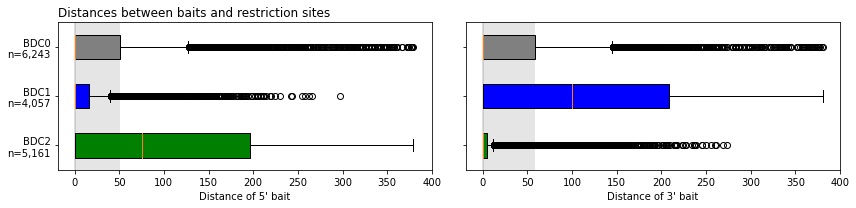

In [19]:
create_boxplot(
    BDC0_L=bdc0_l_dist_list,
    BDC0_R=bdc0_r_dist_list,
    BDC1_L=bdc1_l_dist_list,
    BDC1_R=bdc1_r_dist_list,
    BDC2_L=bdc2_l_dist_list,
    BDC2_R=bdc2_r_dist_list,
    SHOWFLIERS = True,
    TITLE='Distances between baits and restriction sites',
    XLABEL_L='Distance of 5\' bait',
    XLABEL_R='Distance of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_distances_between_baits_and_restriction_sites.pdf')

On the left are the boxplots for the distances of the `5'` baits and on the right the boxplots for the distances of the `3'` baits. The top boxplots (gray) show the distributions of distances for baited digests of the class BDC0. The range between the first and third quantile is highlighted in lightgray. Below the boxplots for BDC0, the boxplots for BDC1 (blue) and BDC2 (green) are shown. The distributions of distances for the `5'` and `3'` baits differ only slightly for BDC0, while they differ clearly for BDC1 and BDC2. The boxplots for BDC1 and BDC2 are asymmetrical to each other.

The boxplots above show the distributions of `5'` and `3'` baits independently. In fact, however, we have a pair of distances for each digest. The following lines of code calculate the differences in distances for each pair.

In [20]:
# Get lists with differences for distances
bdc0_diff_dist_list = [x[0]-x[1] for x in zip(bdc0_l_dist_list, bdc0_r_dist_list)]
bdc1_diff_dist_list = [x[0]-x[1] for x in zip(bdc1_l_dist_list, bdc1_r_dist_list)]
bdc2_diff_dist_list = [x[0]-x[1] for x in zip(bdc2_l_dist_list, bdc2_r_dist_list)]

We use the same plot function as before, but this time, for each baited digest class, we pass the same list of differences for `5'` and `3'` baits. This results in two identical plots. This way we can reuse the plot function.

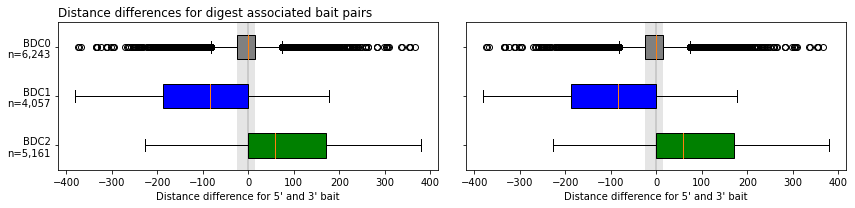

In [21]:
create_boxplot(
    BDC0_L=bdc0_diff_dist_list,
    BDC0_R=bdc0_diff_dist_list,
    BDC1_L=bdc1_diff_dist_list,
    BDC1_R=bdc1_diff_dist_list,
    BDC2_L=bdc2_diff_dist_list,
    BDC2_R=bdc2_diff_dist_list,
    SHOWFLIERS = True,
    TITLE='Distance differences for digest associated bait pairs',
    XLABEL_L='Distance difference for 5\' and 3\' bait',
    XLABEL_R='Distance difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_distance_differences_for_digest_associated_bait_pairs.pdf')

The differences of BDC0 are distributed relatively evenly (not perfectly) around zero. In contrast, a strong asymmetry can be seen for BDC1 and BDC2. To assess the deviations from zero for statistical significance, we use the non-parametric Wilcoxon signed rank test.

In [22]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_dist_list))
print(stats.wilcoxon(bdc1_diff_dist_list))
print(stats.wilcoxon(bdc2_diff_dist_list))

WilcoxonResult(statistic=3293777.0, pvalue=0.004825923561122661)
WilcoxonResult(statistic=246015.5, pvalue=0.0)
WilcoxonResult(statistic=389393.0, pvalue=0.0)


For BDC0, the deviation from zero is statistically significant. This could be due to differing coordinate systems (0-based or 1-based) or differing definition of the exact restriction sites. For BDC1 and BDC2, the P-value is so small that it is reported as zero.

We compare the distributions of differences for all pairs of BDC0, BDC1 and BDC2 using a Wilcoxon rank-sum test.

In [23]:
# Perform Wilcoxon rank-sum test on differences
print(stats.ranksums(bdc0_diff_dist_list, bdc1_diff_dist_list))
print(stats.ranksums(bdc0_diff_dist_list, bdc2_diff_dist_list))
print(stats.ranksums(bdc1_diff_dist_list, bdc2_diff_dist_list))

RanksumsResult(statistic=43.25102148794481, pvalue=0.0)
RanksumsResult(statistic=-43.5739344682971, pvalue=0.0)
RanksumsResult(statistic=-63.160455020285696, pvalue=0.0)


The distributions are very different for all pairs and a P-value of zero is reported in all cases.

**Conclusion:** There is a strong correlation between the placment of baits and the assignment of the digests to the classes BDC0, BDC1 and BDC2. If the baits are not placed right next to the restriction site, the probability that the target sequence is part of a chimeric fragment is reduced.

## Further investigation of digest with two well placed baits

Poor placement of baits obviously has a significant impact on bait efficiency. In order to make more subtle influencing factors visible, we have removed all digests where the distances of the two baits to the digest ends are very different.

||BDC0|BDC1|BDC2|TOTAL|
|---|---|---|---|---|
|ALL|7,061|6,873|8,121|22,055|
|BOTH_SIDES|6,243|4,057|5,161|15,461|
|WELL_PLACED|3,159|1,176|1,821|6,156|

### GC content of baits

First we define a function that that returns the GC and repeat content of a given DNA sequence.

In [24]:
def get_gc_and_repeat_content(sequence):
    
    # Determine GC content
    GC_count = sequence.count('g')
    GC_count += sequence.count('G')
    GC_count += sequence.count('c')
    GC_count += sequence.count('C')
    seq_len = len(sequence)
    gc_content = GC_count/seq_len
    
    # Determine repeat content
    sequence = sub("[a-z]", 'R', sequence)
    R_count = sequence.count('R')
    repeat_content = R_count/seq_len
    
    return gc_content, repeat_content

Here is a fuction call to illustrate how it works.

In [25]:
get_gc_and_repeat_content('NtacgCGCGC')

(0.7, 0.4)

Lowercase letters represent repeats. The GC content is determined without regard to repeats. Positions with `N` are not taken into account when determining the repeat content.

A digest dictionaty with well placed baits is passed to the following function. For each digest, the GC and repeat contents of the two baits are determined and appended to lists that are returned at the end.

In [26]:
def get_gc_and_repeat_content_of_baits(well_placed_baits_dict, bd_classes=[0,1,2]):
    l_gc_list = []
    r_gc_list = []
    l_repeat_list = []
    r_repeat_list = []
    for d_key in well_placed_baits_dict.keys():
    
        # Filter for digests with specified baited digest classes
        if well_placed_baits_dict[d_key]['BDC'] not in bd_classes:
            continue

        # Get GC and repeat content of 5' bait
        seq = BAIT_SEQ_dict[well_placed_baits_dict[d_key]['L_COORDS'][0]]
        gc_content, repeat_content = get_gc_and_repeat_content(seq)
        l_gc_list.append(gc_content)
        l_repeat_list.append(repeat_content)

        # Get GC and repeat content of 3' bait
        seq = BAIT_SEQ_dict[well_placed_baits_dict[d_key]['R_COORDS'][0]]
        gc_content, repeat_content = get_gc_and_repeat_content(seq)
        r_gc_list.append(gc_content)
        r_repeat_list.append(repeat_content)
      
    print('BDC' + str(bd_classes))
    print('GC contents 5\' baits: ' + '{:,}'.format(len(l_gc_list)))
    print('GC contents 3\' baits: ' + '{:,}'.format(len(r_gc_list)))
    print('Repeat contents 5\' baits: ' + '{:,}'.format(len(l_repeat_list)))
    print('Repeat contents 3\' baits: ' + '{:,}'.format(len(r_repeat_list)))
    print()
        
    return l_gc_list, r_gc_list, l_repeat_list, r_repeat_list

We use this funtion to generate separate lists with GC and repeat contents for the baited digests of the different classes.

In [27]:
bdc0_l_gc_list, bdc0_r_gc_list, bdc0_l_repeat_list, bdc0_r_repeat_list = get_gc_and_repeat_content_of_baits(
    bdc0_well_placed_dict,
    bd_classes=[0])

bdc1_l_gc_list, bdc1_r_gc_list, bdc1_l_repeat_list, bdc1_r_repeat_list = get_gc_and_repeat_content_of_baits(
    bdc1_well_placed_dict,
    bd_classes=[1])

bdc2_l_gc_list, bdc2_r_gc_list, bdc2_l_repeat_list, bdc2_r_repeat_list = get_gc_and_repeat_content_of_baits(
    bdc2_well_placed_dict,
    bd_classes=[2])

BDC[0]
GC contents 5' baits: 3,159
GC contents 3' baits: 3,159
Repeat contents 5' baits: 3,159
Repeat contents 3' baits: 3,159

BDC[1]
GC contents 5' baits: 1,176
GC contents 3' baits: 1,176
Repeat contents 5' baits: 1,176
Repeat contents 3' baits: 1,176

BDC[2]
GC contents 5' baits: 1,821
GC contents 3' baits: 1,821
Repeat contents 5' baits: 1,821
Repeat contents 3' baits: 1,821



Then we use our boxplot function to compare the distributions of GC contents.

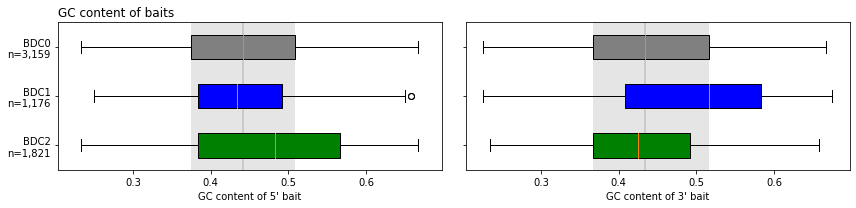

In [28]:
create_boxplot(
    BDC0_L=bdc0_l_gc_list,
    BDC0_R=bdc0_r_gc_list,
    BDC1_L=bdc1_l_gc_list,
    BDC1_R=bdc1_r_gc_list,
    BDC2_L=bdc2_l_gc_list,
    BDC2_R=bdc2_r_gc_list,
    SHOWFLIERS = True,
    TITLE='GC content of baits',
    XLABEL_L='GC content of 5\' bait',
    XLABEL_R='GC content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_baits.pdf')

For BDC0, the GC contents of the `5'` and `3'` baits show a similar distribution. In contrast, these distributions are very different for BDC1 and BDC2. For BCD1, the distribution for the `3'` baits is shifted towards larger GC contents. For BDC2, it is the other way arround. Here the distribution for the `5'` is shifted towards larger GC contents. This could indicate that too high GC content has a negative impact on the efficiency of baits.

We again determine the differences for the bait pairs of all digests, as we did for the distances from baits to digest ends, but this time for the GC contents.

In [29]:
# Get lists with differences for GC content
bdc0_diff_gc_list = [x[0]-x[1] for x in zip(bdc0_l_gc_list, bdc0_r_gc_list)]
bdc1_diff_gc_list = [x[0]-x[1] for x in zip(bdc1_l_gc_list, bdc1_r_gc_list)]
bdc2_diff_gc_list = [x[0]-x[1] for x in zip(bdc2_l_gc_list, bdc2_r_gc_list)]

Then we use our boxplot function to visualize the distributions of differences. Remember that in this case the boxplots on the left and right are identical.

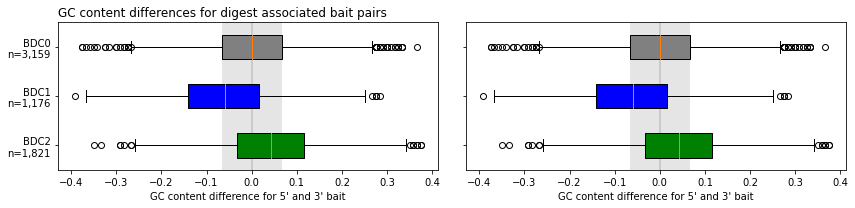

In [30]:
create_boxplot(
    BDC0_L=bdc0_diff_gc_list,
    BDC0_R=bdc0_diff_gc_list,
    BDC1_L=bdc1_diff_gc_list,
    BDC1_R=bdc1_diff_gc_list,
    BDC2_L=bdc2_diff_gc_list,
    BDC2_R=bdc2_diff_gc_list,
    SHOWFLIERS = True,
    TITLE='GC content differences for digest associated bait pairs',
    XLABEL_L='GC content difference for 5\' and 3\' bait',
    XLABEL_R='GC content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_digest_associated_bait_pairs.pdf')

For BDC0, the differences are evenly distributed around zero. For BDC1, the distribution is shifted towards negative differences. This means that there are many bait pairs for which the GC content of the `3'` bait is higher than that of the `5'` bait. For BDC2 it is the exact opposite. Here, there are many pairs where the GC content of the `5'` bait is higher.

We use the Wilcoxon signed rank test to test the deviations from zero for statistical significance.

In [31]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_gc_list))
print(stats.wilcoxon(bdc1_diff_gc_list))
print(stats.wilcoxon(bdc2_diff_gc_list))

WilcoxonResult(statistic=2253048.0, pvalue=0.16592618345888333)
WilcoxonResult(statistic=154646.0, pvalue=8.98590648416848e-55)
WilcoxonResult(statistic=463349.5, pvalue=3.613982559827672e-53)


For BDC0, the differences do not deviate significantly from zero. For BDC1 and BDC2, the deviations are significant.

We use the Wilcoxon rank sum test to test the null hypothesis that the differences for BDC0, BDC1 and BDC2 come from the same distribution.

In [32]:
# Perform Wilcoxon rank-sum test on differences
print(stats.ranksums(bdc0_diff_gc_list, bdc1_diff_gc_list))
print(stats.ranksums(bdc0_diff_gc_list, bdc2_diff_gc_list))
print(stats.ranksums(bdc1_diff_gc_list, bdc2_diff_gc_list))

RanksumsResult(statistic=15.90535841175949, pvalue=5.816945131008616e-57)
RanksumsResult(statistic=-12.709826487016521, pvalue=5.215002464053893e-37)
RanksumsResult(statistic=-21.856526749991332, pvalue=6.738016863526015e-106)


The distributions of differences for BDC0, BDC1 and BDC2 differ significantly from each other.

### Repeat content of baits

For the repeat content of baits, we perform the same analysis as for the GC content of baits. As before, we use the digest with two well-placed baits for our analysis. First, we create the boxplots showing the distributions of repeat contents separately for `5'` and `3'` baits.

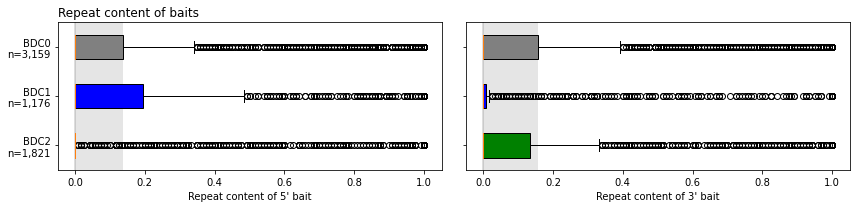

In [33]:
create_boxplot(
    BDC0_L=bdc0_l_repeat_list,
    BDC0_R=bdc0_r_repeat_list,
    BDC1_L=bdc1_l_repeat_list,
    BDC1_R=bdc1_r_repeat_list,
    BDC2_L=bdc2_l_repeat_list,
    BDC2_R=bdc2_r_repeat_list,
    SHOWFLIERS = True,
    TITLE='Repeat content of baits',
    XLABEL_L='Repeat content of 5\' bait',
    XLABEL_R='Repeat content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_baits.pdf')

For BDC0, the repeat content distributions of `5'` and `3'` baits are similar. For BDC1 and BDC2, these distributions are very different. For BDC1, most of the repeat contents of the `3'` baits seem to be zero and, for BDC2, it is the exact opposite.

We again determine the differences of repeat contents for all bait pairs and create boxplots.

In [34]:
## Get lists with differences for repeat content
bdc0_diff_repeat_list = [x[0]-x[1] for x in zip(bdc0_l_repeat_list, bdc0_r_repeat_list)]
bdc1_diff_repeat_list = [x[0]-x[1] for x in zip(bdc1_l_repeat_list, bdc1_r_repeat_list)]
bdc2_diff_repeat_list = [x[0]-x[1] for x in zip(bdc2_l_repeat_list, bdc2_r_repeat_list)]

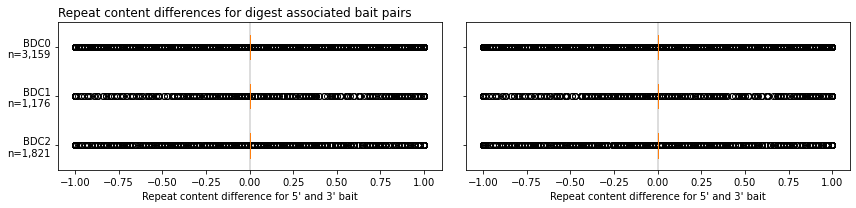

In [35]:
create_boxplot(
    BDC0_L=bdc0_diff_repeat_list,
    BDC0_R=bdc0_diff_repeat_list,
    BDC1_L=bdc1_diff_repeat_list,
    BDC1_R=bdc1_diff_repeat_list,
    BDC2_L=bdc2_diff_repeat_list,
    BDC2_R=bdc2_diff_repeat_list,
    SHOWFLIERS = True,
    TITLE='Repeat content differences for digest associated bait pairs',
    XLABEL_L='Repeat content difference for 5\' and 3\' bait',
    XLABEL_R='Repeat content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_differences_for_digest_associated_bait_pairs.pdf')

Then we perform the statistical tests.

In [36]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_repeat_list))
print(stats.wilcoxon(bdc1_diff_repeat_list))
print(stats.wilcoxon(bdc2_diff_repeat_list))

WilcoxonResult(statistic=547994.5, pvalue=0.8233862448437836)
WilcoxonResult(statistic=58838.5, pvalue=0.0002469415396608193)
WilcoxonResult(statistic=140389.5, pvalue=0.0011248591076851995)


Judging by the test, the differences for BDC1 and BDC2 deviate significantly from zero, but not for BDC0.

In [37]:
# Perform Wilcoxon rank_sum test on differences
print(stats.ranksums(bdc0_diff_repeat_list, bdc1_diff_repeat_list))
print(stats.ranksums(bdc0_diff_repeat_list, bdc2_diff_repeat_list))
print(stats.ranksums(bdc1_diff_repeat_list, bdc2_diff_repeat_list))

RanksumsResult(statistic=-2.070265097322163, pvalue=0.0384275261550298)
RanksumsResult(statistic=1.9547652357266543, pvalue=0.05061078620626512)
RanksumsResult(statistic=3.409944323353017, pvalue=0.000649761425680528)


BDC1 and BDC2 differ only slightly from BDC0. But among themselves, BDC1 and BDC2 differ significantly.

#### Remove all digests for which the repeat content of both baits is zero

The boxplot for the repeat content of BDC1 `3'` baits and the BDC2 `5'` baits look strange. This is because in these cases the repeat content is zero for more than 75% of the digests.

In [38]:
print('5\' baits')
print('BDC0: ' + '{:.2f}'.format(bdc0_l_repeat_list.count(0.00)/len(bdc0_l_repeat_list)))
print('BDC1: ' + '{:.2f}'.format(bdc1_l_repeat_list.count(0.00)/len(bdc1_l_repeat_list)))
print('BDC2: ' + '{:.2f}'.format(bdc2_l_repeat_list.count(0.00)/len(bdc2_l_repeat_list)) + ' !')
print()
print('3\' baits')
print('BDC0: ' + '{:.2f}'.format(bdc0_r_repeat_list.count(0.00)/len(bdc0_r_repeat_list)))
print('BDC1: ' + '{:.2f}'.format(bdc1_r_repeat_list.count(0.00)/len(bdc1_r_repeat_list)) + ' !')
print('BDC2: ' + '{:.2f}'.format(bdc2_r_repeat_list.count(0.00)/len(bdc2_r_repeat_list)))

5' baits
BDC0: 0.71
BDC1: 0.71
BDC2: 0.75 !

3' baits
BDC0: 0.71
BDC1: 0.75 !
BDC2: 0.72


More than half of the differences are also equal zero.

In [39]:
print('Differences between 5\' and 3\' baits')
print('BDC0: ' + '{:.2f}'.format(bdc0_diff_repeat_list.count(0.00)/len(bdc0_diff_repeat_list)))
print('BDC1: ' + '{:.2f}'.format(bdc1_diff_repeat_list.count(0.00)/len(bdc1_diff_repeat_list)))
print('BDC2: ' + '{:.2f}'.format(bdc2_diff_repeat_list.count(0.00)/len(bdc2_diff_repeat_list)))

Differences between 5' and 3' baits
BDC0: 0.53
BDC1: 0.54
BDC2: 0.56


This means that more than the half of the digests have two baits with no repeats. These digests are not informative for this analysis (true?) and they interfere with the display in the boxplots. Therefore, we removed all digests for which the repeat content of both digests is zero.

In [40]:
bdc0_l_repeat_list_f1, bdc0_r_repeat_list_f1, bdc0_l_gc_list_f1, bdc0_r_gc_list_f1 = \
    zip(*list(filter(lambda x: 0<x[0] or 0<x[1], zip(bdc0_l_repeat_list, bdc0_r_repeat_list, bdc0_l_gc_list, bdc0_r_gc_list))))

bdc1_l_repeat_list_f1, bdc1_r_repeat_list_f1, bdc1_l_gc_list_f1, bdc1_r_gc_list_f1 = \
    zip(*list(filter(lambda x: 0<x[0] or 0<x[1], zip(bdc1_l_repeat_list, bdc1_r_repeat_list, bdc1_l_gc_list, bdc1_r_gc_list))))

bdc2_l_repeat_list_f1, bdc2_r_repeat_list_f1, bdc2_l_gc_list_f1, bdc2_r_gc_list_f1 = \
    zip(*list(filter(lambda x: 0<x[0] or 0<x[1], zip(bdc2_l_repeat_list, bdc2_r_repeat_list, bdc2_l_gc_list, bdc2_r_gc_list))))

Then we plotted the repeat content of the remaining pairs in a boxplot.

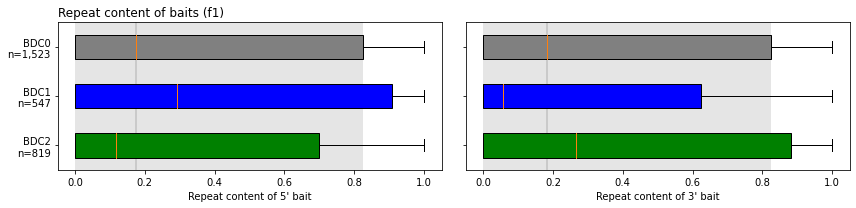

In [41]:
create_boxplot(
    BDC0_L=bdc0_l_repeat_list_f1,
    BDC0_R=bdc0_r_repeat_list_f1,
    BDC1_L=bdc1_l_repeat_list_f1,
    BDC1_R=bdc1_r_repeat_list_f1,
    BDC2_L=bdc2_l_repeat_list_f1,
    BDC2_R=bdc2_r_repeat_list_f1,
    SHOWFLIERS = True,
    TITLE='Repeat content of baits (f1)',
    XLABEL_L='Repeat content of 5\' bait',
    XLABEL_R='Repeat content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_baits_f1.pdf')

For BDC0, the distributions of the repeat contents of `5'` and `3'` baits are almost the same. For BCD1, the `3'` baits have lower repeat content and, for BDC2, the `5'` baits have lower repeat content. This contradicts the explanatory model with the unequal efficiency of baits. Normally, baits with higher repeat content are assumed to less efficient because they bind not only to the target region, but to other regions as well.

We again determine the differences of repeat contents for all bait pairs, create boxplots and perform the statistical tests.

In [42]:
# Get lists with differences for repeat content (filtered)
bdc0_diff_repeat_list_f1 = [x[0]-x[1] for x in zip(bdc0_l_repeat_list_f1, bdc0_r_repeat_list_f1)]
bdc1_diff_repeat_list_f1 = [x[0]-x[1] for x in zip(bdc1_l_repeat_list_f1, bdc1_r_repeat_list_f1)]
bdc2_diff_repeat_list_f1 = [x[0]-x[1] for x in zip(bdc2_l_repeat_list_f1, bdc2_r_repeat_list_f1)]

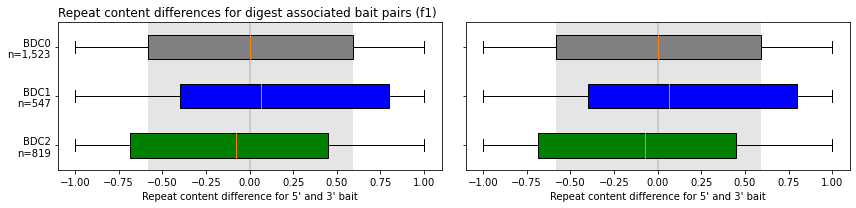

In [43]:
create_boxplot(
    BDC0_L=bdc0_diff_repeat_list_f1,
    BDC0_R=bdc0_diff_repeat_list_f1,
    BDC1_L=bdc1_diff_repeat_list_f1,
    BDC1_R=bdc1_diff_repeat_list_f1,
    BDC2_L=bdc2_diff_repeat_list_f1,
    BDC2_R=bdc2_diff_repeat_list_f1,
    SHOWFLIERS = True,
    TITLE='Repeat content differences for digest associated bait pairs (f1)',
    XLABEL_L='Repeat content difference for 5\' and 3\' bait',
    XLABEL_R='Repeat content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_differences_for_digest_associated_bait_pairs_f1.pdf')

For BDC0, the differences are evenly distributed around zero. For BDC1, the repeat content of the `3'` bait is often less than that of the `5'` bait and, for BDC2, the opposite is true.

In [44]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_repeat_list_f1))
print(stats.wilcoxon(bdc1_diff_repeat_list_f1))
print(stats.wilcoxon(bdc2_diff_repeat_list_f1))

WilcoxonResult(statistic=547994.5, pvalue=0.8233862448437836)
WilcoxonResult(statistic=58838.5, pvalue=0.0002469415396608193)
WilcoxonResult(statistic=140389.5, pvalue=0.0011248591076851995)


In [45]:
# Perform Wilcoxon rank-sum test on differences
print(stats.ranksums(bdc0_diff_repeat_list_f1, bdc1_diff_repeat_list_f1))
print(stats.ranksums(bdc0_diff_repeat_list_f1, bdc2_diff_repeat_list_f1))
print(stats.ranksums(bdc1_diff_repeat_list_f1, bdc2_diff_repeat_list_f1))

RanksumsResult(statistic=-3.308492136446071, pvalue=0.0009379981893620771)
RanksumsResult(statistic=2.490252078338261, pvalue=0.012765252106175703)
RanksumsResult(statistic=4.8897649913450545, pvalue=1.0095643325669406e-06)


The results of the statistical tests are not very different from those obtained before we removed all digests that have two baits without repeats.

Repeat GC content analysis for non-zero repeat digests.

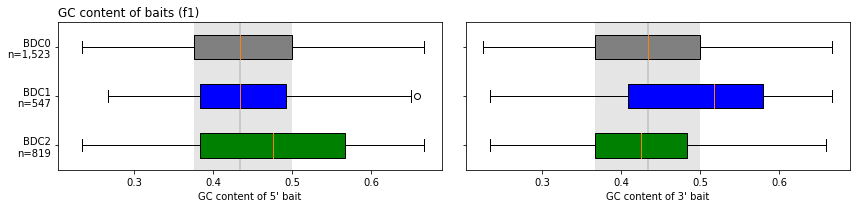

In [46]:
create_boxplot(
    BDC0_L=bdc0_l_gc_list_f1,
    BDC0_R=bdc0_r_gc_list_f1,
    BDC1_L=bdc1_l_gc_list_f1,
    BDC1_R=bdc1_r_gc_list_f1,
    BDC2_L=bdc2_l_gc_list_f1,
    BDC2_R=bdc2_r_gc_list_f1,
    SHOWFLIERS = True,
    TITLE='GC content of baits (f1)',
    XLABEL_L='GC content of 5\' bait',
    XLABEL_R='GC content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_baits_f1.pdf')

In [47]:
# Get lists with differences for gc content (filtered)
bdc0_diff_gc_list_f1 = [x[0]-x[1] for x in zip(bdc0_l_gc_list_f1, bdc0_r_gc_list_f1)]
bdc1_diff_gc_list_f1 = [x[0]-x[1] for x in zip(bdc1_l_gc_list_f1, bdc1_r_gc_list_f1)]
bdc2_diff_gc_list_f1 = [x[0]-x[1] for x in zip(bdc2_l_gc_list_f1, bdc2_r_gc_list_f1)]

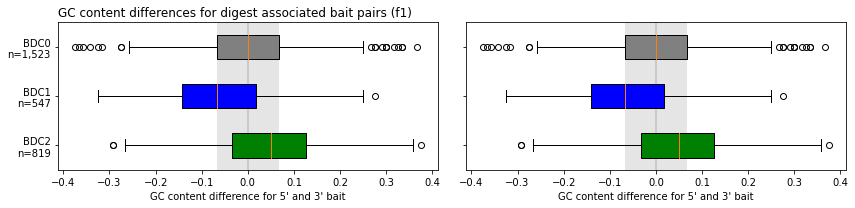

In [48]:
create_boxplot(
    BDC0_L=bdc0_diff_gc_list_f1,
    BDC0_R=bdc0_diff_gc_list_f1,
    BDC1_L=bdc1_diff_gc_list_f1,
    BDC1_R=bdc1_diff_gc_list_f1,
    BDC2_L=bdc2_diff_gc_list_f1,
    BDC2_R=bdc2_diff_gc_list_f1,
    SHOWFLIERS = True,
    TITLE='GC content differences for digest associated bait pairs (f1)',
    XLABEL_L='GC content difference for 5\' and 3\' bait',
    XLABEL_R='GC content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_differences_for_digest_associated_bait_pairs_f1.pdf')

In [49]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_gc_list_f1))
print(stats.wilcoxon(bdc1_diff_gc_list_f1))
print(stats.wilcoxon(bdc2_diff_gc_list_f1))

WilcoxonResult(statistic=519767.0, pvalue=0.4539917275579477)
WilcoxonResult(statistic=32151.5, pvalue=9.113607922985743e-28)
WilcoxonResult(statistic=93708.5, pvalue=1.7393753247979323e-24)


### Dependency between GC and repeat content

High GC content could be negatively correlated with repeat content. To test this hypothesis, we determined the GC and repeat content of all baits.

In [50]:
# Get GC and repeat content of all baits
gc_list = []
repeat_list = []
for bait_seq in BAIT_SEQ_dict.values():
    gc_content, repeat_content = get_gc_and_repeat_content(bait_seq)
    gc_list.append(gc_content)
    repeat_list.append(repeat_content)

Then we divide all baits into those with and without repeats, and within these groups, we further divide them into low and high GC baits. To distinguish between low and high GC baits, we use the median GC content of all baits as a threshold. Then we determine the numbers of baits in the four groups and perform a Fisher's exact test.

In [51]:
GC_LOW_HIGH_THRESH = median(gc_list)
print('GC_LOW_HIGH_THRESH: ' + '{:.2f}'.format(GC_LOW_HIGH_THRESH))
print()
x, y = \
    zip(*list(filter(lambda x: x[0]==0 and x[1]<=GC_LOW_HIGH_THRESH, zip(repeat_list, gc_list))))
ZERO_REPEAT_GC_LOW = len(y)
x, y = \
    zip(*list(filter(lambda x: x[0]==0 and x[1]>GC_LOW_HIGH_THRESH, zip(repeat_list, gc_list))))
ZERO_REPEAT_GC_HIGH = len(y)
x, y = \
    zip(*list(filter(lambda x: x[0]>0 and x[1]<=GC_LOW_HIGH_THRESH, zip(repeat_list, gc_list))))
NON_ZERO_REPEAT_GC_LOW = len(y)
x, y = \
    zip(*list(filter(lambda x: x[0]>0 and x[1]>GC_LOW_HIGH_THRESH, zip(repeat_list, gc_list))))
NON_ZERO_REPEAT_GC_HIGH = len(y)

ZERO_REPEAT_TOTAL = ZERO_REPEAT_GC_LOW + ZERO_REPEAT_GC_HIGH
NON_ZERO_REPEAT_TOTAL = NON_ZERO_REPEAT_GC_LOW + NON_ZERO_REPEAT_GC_HIGH
GC_LOW_TOTAL = ZERO_REPEAT_GC_LOW + NON_ZERO_REPEAT_GC_LOW
GC_HIGH_TOTAL = ZERO_REPEAT_GC_HIGH + NON_ZERO_REPEAT_GC_HIGH

d = {'Low GC': ['{:,}'.format(ZERO_REPEAT_GC_LOW),
                '{:,}'.format(NON_ZERO_REPEAT_GC_LOW),
                '{:,}'.format(GC_LOW_TOTAL)],
     'High GC': ['{:,}'.format(ZERO_REPEAT_GC_HIGH),
                 '{:,}'.format(NON_ZERO_REPEAT_GC_HIGH),
                 '{:,}'.format(GC_HIGH_TOTAL)],
     'Total': ['{:,}'.format(ZERO_REPEAT_TOTAL),
               '{:,}'.format(NON_ZERO_REPEAT_TOTAL),
               '{:,}'.format(ZERO_REPEAT_TOTAL + NON_ZERO_REPEAT_TOTAL)]}
df = pd.DataFrame(data=d)
df.index = ['Zero repeat', 'Non-zero repeat', 'Total']
print(df)

# Fisher's exact test
contingency_table = [
    [ZERO_REPEAT_GC_LOW, ZERO_REPEAT_GC_HIGH],
    [NON_ZERO_REPEAT_GC_LOW, NON_ZERO_REPEAT_GC_HIGH]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

GC_LOW_HIGH_THRESH: 0.43

                 Low GC High GC   Total
Zero repeat      11,607  12,380  23,987
Non-zero repeat   7,724   5,891  13,615
Total            19,331  18,271  37,602
Prior odds ratio: 0.7150659484860984
P-value: 1.251786508767154e-54


Among the baits with a high GC content, the proportion of baits without repeats is significantly higher.

### Remove digests in which one of the baits has very high GC content

We have removed all digests for which at least one of the baits has a GC content of more than that of 75% of all baits, which is `0.52`.

In [52]:
GC_HIGH_THRESH = quantile(gc_list, 0.75)
print(GC_HIGH_THRESH)

0.5166666666666667


In [53]:
bdc0_l_gc_list_f2, bdc0_r_gc_list_f2, bdc0_l_repeat_list_f2, bdc0_r_repeat_list_f2 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH and (0<x[2] or 0<x[3]), zip(bdc0_l_gc_list, bdc0_r_gc_list, bdc0_l_repeat_list, bdc0_r_repeat_list))))

bdc1_l_gc_list_f2, bdc1_r_gc_list_f2, bdc1_l_repeat_list_f2, bdc1_r_repeat_list_f2 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH and (0<x[2] or 0<x[3]), zip(bdc1_l_gc_list, bdc1_r_gc_list, bdc1_l_repeat_list, bdc1_r_repeat_list))))

bdc2_l_gc_list_f2, bdc2_r_gc_list_f2, bdc2_l_repeat_list_f2, bdc2_r_repeat_list_f2 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH and (0<x[2] or 0<x[3]), zip(bdc2_l_gc_list, bdc2_r_gc_list, bdc2_l_repeat_list, bdc2_r_repeat_list))))

First, we run the analysis for GC content again using the filtered data.

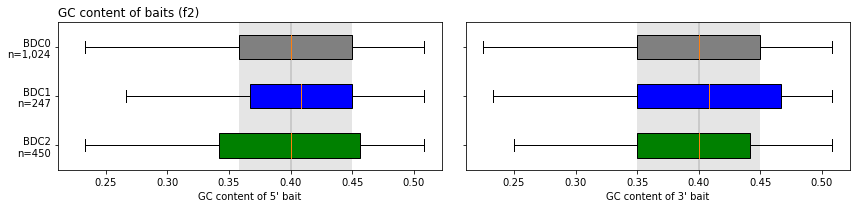

In [54]:
create_boxplot(
    BDC0_L=bdc0_l_gc_list_f2,
    BDC0_R=bdc0_r_gc_list_f2,
    BDC1_L=bdc1_l_gc_list_f2,
    BDC1_R=bdc1_r_gc_list_f2,
    BDC2_L=bdc2_l_gc_list_f2,
    BDC2_R=bdc2_r_gc_list_f2,
    SHOWFLIERS = True,
    TITLE='GC content of baits (f2)',
    XLABEL_L='GC content of 5\' bait',
    XLABEL_R='GC content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_baits_f2.pdf')

In [55]:
# Get lists with differences for GC content (x)
bdc0_diff_gc_list_f2 = [x[0]-x[1] for x in zip(bdc0_l_gc_list_f2, bdc0_r_gc_list_f2)]
bdc1_diff_gc_list_f2 = [x[0]-x[1] for x in zip(bdc1_l_gc_list_f2, bdc1_r_gc_list_f2)]
bdc2_diff_gc_list_f2 = [x[0]-x[1] for x in zip(bdc2_l_gc_list_f2, bdc2_r_gc_list_f2)]

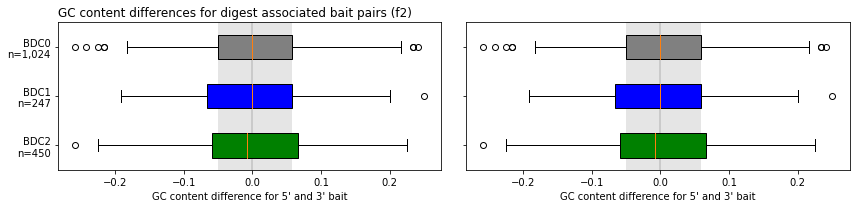

In [56]:
create_boxplot(
    BDC0_L=bdc0_diff_gc_list_f2,
    BDC0_R=bdc0_diff_gc_list_f2,
    BDC1_L=bdc1_diff_gc_list_f2,
    BDC1_R=bdc1_diff_gc_list_f2,
    BDC2_L=bdc2_diff_gc_list_f2,
    BDC2_R=bdc2_diff_gc_list_f2,
    SHOWFLIERS = True,
    TITLE='GC content differences for digest associated bait pairs (f2)',
    XLABEL_L='GC content difference for 5\' and 3\' bait',
    XLABEL_R='GC content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_differences_for_digest_associated_bait_pairs_f2.pdf')

In [57]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_gc_list_f2))
print(stats.wilcoxon(bdc1_diff_gc_list_f2))
print(stats.wilcoxon(bdc2_diff_gc_list_f2))

WilcoxonResult(statistic=226573.0, pvalue=0.3080445367057454)
WilcoxonResult(statistic=13570.5, pvalue=0.8643841661478169)
WilcoxonResult(statistic=45684.5, pvalue=0.5094077524406313)


In [58]:
# Perform Wilcoxon rank_sum test on differences
print(stats.ranksums(bdc0_diff_gc_list_f2, bdc1_diff_gc_list_f2))
print(stats.ranksums(bdc0_diff_gc_list_f2, bdc2_diff_gc_list_f2))
print(stats.ranksums(bdc1_diff_gc_list_f2, bdc2_diff_gc_list_f2))

RanksumsResult(statistic=0.6498807619390385, pvalue=0.5157692457921998)
RanksumsResult(statistic=1.091090752338031, pvalue=0.2752329515936829)
RanksumsResult(statistic=0.22456614638139918, pvalue=0.82231680349383)


**No significant deviations from zero!**

Run the repeat content analysis again using the filtered data.

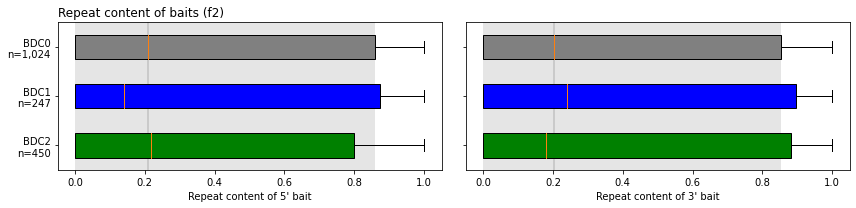

In [59]:
create_boxplot(
    BDC0_L=bdc0_l_repeat_list_f2,
    BDC0_R=bdc0_r_repeat_list_f2,
    BDC1_L=bdc1_l_repeat_list_f2,
    BDC1_R=bdc1_r_repeat_list_f2,
    BDC2_L=bdc2_l_repeat_list_f2,
    BDC2_R=bdc2_r_repeat_list_f2,
    SHOWFLIERS = True,
    TITLE='Repeat content of baits (f2)',
    XLABEL_L='Repeat content of 5\' bait',
    XLABEL_R='Repeat content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_baits_f2.pdf')

In [60]:
# Get lists with differences for repeat content (x)
bdc0_diff_repeat_list_f2 = [x[0]-x[1] for x in zip(bdc0_l_repeat_list_f2, bdc0_r_repeat_list_f2)]
bdc1_diff_repeat_list_f2 = [x[0]-x[1] for x in zip(bdc1_l_repeat_list_f2, bdc1_r_repeat_list_f2)]
bdc2_diff_repeat_list_f2 = [x[0]-x[1] for x in zip(bdc2_l_repeat_list_f2, bdc2_r_repeat_list_f2)]

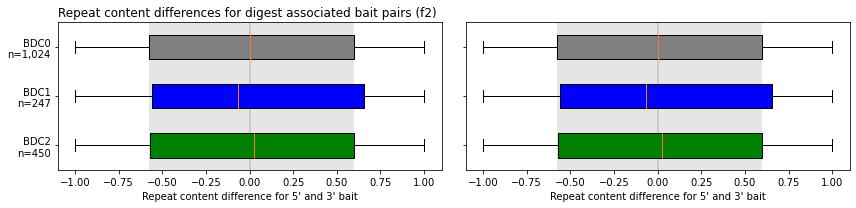

In [61]:
create_boxplot(
    BDC0_L=bdc0_diff_repeat_list_f2,
    BDC0_R=bdc0_diff_repeat_list_f2,
    BDC1_L=bdc1_diff_repeat_list_f2,
    BDC1_R=bdc1_diff_repeat_list_f2,
    BDC2_L=bdc2_diff_repeat_list_f2,
    BDC2_R=bdc2_diff_repeat_list_f2,
    SHOWFLIERS = True,
    TITLE='Repeat content differences for digest associated bait pairs (f2)',
    XLABEL_L='Repeat content difference for 5\' and 3\' bait',
    XLABEL_R='Repeat content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_differences_for_digest_associated_bait_pairs_f2.pdf')

In [62]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_repeat_list_f2))
print(stats.wilcoxon(bdc1_diff_repeat_list_f2))
print(stats.wilcoxon(bdc2_diff_repeat_list_f2))

WilcoxonResult(statistic=247722.5, pvalue=0.9971357805202811)
WilcoxonResult(statistic=13846.0, pvalue=0.7242214103095929)
WilcoxonResult(statistic=48172.5, pvalue=0.9646823835905931)


In [63]:
# Perform Wilcoxon rank_sum test on differences
print(stats.ranksums(bdc0_diff_repeat_list_f2, bdc1_diff_repeat_list_f2))
print(stats.ranksums(bdc0_diff_repeat_list_f2, bdc2_diff_repeat_list_f2))
print(stats.ranksums(bdc1_diff_repeat_list_f2, bdc2_diff_repeat_list_f2))

RanksumsResult(statistic=0.3669460468600812, pvalue=0.713659263171951)
RanksumsResult(statistic=-0.07088801271050839, pvalue=0.9434868838452237)
RanksumsResult(statistic=-0.37342479157467345, pvalue=0.7088323107956839)


**No significant deviations from zero!**

### Write files for accessibility analysis

First, we determine the counts of BDC1 and BDC2 digests without high GC baits for control purposes.

In [64]:
bdc0_l_gc_list_f3, bdc0_r_gc_list_f3, bdc0_l_repeat_list_f3, bdc0_r_repeat_list_f3 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH, zip(bdc0_l_gc_list, bdc0_r_gc_list, bdc0_l_repeat_list, bdc0_r_repeat_list))))

bdc1_l_gc_list_f3, bdc1_r_gc_list_f3, bdc1_l_repeat_list_f3, bdc1_r_repeat_list_f3 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH, zip(bdc1_l_gc_list, bdc1_r_gc_list, bdc1_l_repeat_list, bdc1_r_repeat_list))))

bdc2_l_gc_list_f3, bdc2_r_gc_list_f3, bdc2_l_repeat_list_f3, bdc2_r_repeat_list_f3 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH, zip(bdc2_l_gc_list, bdc2_r_gc_list, bdc2_l_repeat_list, bdc2_r_repeat_list))))

In [65]:
print(len(bdc0_l_gc_list_f3))
print(len(bdc0_r_gc_list_f3))
print(len(bdc1_l_gc_list_f3))
print(len(bdc1_r_gc_list_f3))
print(len(bdc2_l_gc_list_f3))
print(len(bdc2_r_gc_list_f3))

1984
1984
513
513
931
931


In [66]:
# Iterate well placed digests and skip digests with high GC content
a11y_bdc0_set = set()
for bd_key in bdc0_well_placed_dict.keys():
    #print(bd_key)
    # Determine GC content of baits
    seq_l = BAIT_SEQ_dict[bdc0_well_placed_dict[bd_key]['L_COORDS'][0]]
    seq_r = BAIT_SEQ_dict[bdc0_well_placed_dict[bd_key]['R_COORDS'][0]]
    gc_content_l, repeat_content_l = get_gc_and_repeat_content(seq_l)
    gc_content_r, repeat_content_r = get_gc_and_repeat_content(seq_r)
    gc_content_max = max([gc_content_l, gc_content_r])
    # Add key to set if condition is met
    if gc_content_max<GC_HIGH_THRESH:
        a11y_bdc0_set.add(bd_key)
print(len(a11y_bdc0_set))

a11y_bdc1_set = set()
for bd_key in bdc1_well_placed_dict.keys():
    #print(bd_key)
    # Determine GC content of baits
    seq_l = BAIT_SEQ_dict[bdc1_well_placed_dict[bd_key]['L_COORDS'][0]]
    seq_r = BAIT_SEQ_dict[bdc1_well_placed_dict[bd_key]['R_COORDS'][0]]
    gc_content_l, repeat_content_l = get_gc_and_repeat_content(seq_l)
    gc_content_r, repeat_content_r = get_gc_and_repeat_content(seq_r)
    gc_content_max = max([gc_content_l, gc_content_r])
    # Add key to set if condition is met
    if gc_content_max<GC_HIGH_THRESH:
        a11y_bdc1_set.add(bd_key)
print(len(a11y_bdc1_set))

a11y_bdc2_set = set()
for bd_key in bdc2_well_placed_dict.keys():
    # Determine GC content of baits
    seq_l = BAIT_SEQ_dict[bdc2_well_placed_dict[bd_key]['L_COORDS'][0]]
    seq_r = BAIT_SEQ_dict[bdc2_well_placed_dict[bd_key]['R_COORDS'][0]]
    gc_content_l, repeat_content_l = get_gc_and_repeat_content(seq_l)
    gc_content_r, repeat_content_r = get_gc_and_repeat_content(seq_r)
    gc_content_max = max([gc_content_l, gc_content_r])
    # Add key to set if condition is met
    if gc_content_max<GC_HIGH_THRESH:
        a11y_bdc2_set.add(bd_key)
print(len(a11y_bdc2_set))

fh = open(NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX + '_bdc1_a11y.bed', 'wt')
fh.write("track name=\"" + OUT_PREFIX + "_bdc1_a11y\" description=\"" + OUT_PREFIX + "- BDC1-A11Y\" itemRgb=\"On\"" + '\n')
for interval in BDC1_DIGEST_FILE:
    bd_key = interval.chrom + '\t' + str(interval.start) + '\t' + str(interval.end)
    #if bd_key in a11y_bdc1_set: # Comment this in to filter out digests with high GC baits
    if bd_key in bdc1_well_placed_dict:
        fh.write(str(interval).rstrip() + '\n')
fh.close()

fh = open(NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX + '_bdc2_a11y.bed', 'wt')
fh.write("track name=\"" + OUT_PREFIX + "_bdc2_a11y\" description=\"" + OUT_PREFIX + "- BDC2-A11Y\" itemRgb=\"On\"" + '\n')
for interval in BDC2_DIGEST_FILE:
    bd_key = interval.chrom + '\t' + str(interval.start) + '\t' + str(interval.end)
    #if bd_key in a11y_bdc2_set: # Comment this in to filter out digests with high GC baits
    if bd_key in bdc2_well_placed_dict:
        fh.write(str(interval).rstrip() + '\n')
fh.close()

1984
513
931


For now, we are not filtering out digests with high GC baits because we don't know if there is a correlation between GC content and accessibility.

## Average read pair counts for BDC0, BDC1 and BDC2

In [67]:
import sys
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet

In [68]:
CELL_TYPE_SHORT = 'MAC_M0'
PROTOCOL = 'CHC'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'ht'
FDR = '05'
if PROTOCOL == 'CHC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_CHC_RALT_' + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC_POOLED':
    INTERACTION_FILE = '../DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + 'POOLED_HC_FDR005' + '_HC_RALT_20000_' + RPC_RULE.lower()
if PROTOCOL == 'HC':
    INTERACTION_FILE = '../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/HC/' + MIN_I_DIST + '/JAV_' + CELL_TYPE_SHORT + '_HC_RALT_' + MIN_I_DIST + '_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_HC_RALT_'  + MIN_I_DIST + '_' + RPC_RULE.lower()

In [69]:
# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet(rpc_rule = 'ht')
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)
# Create BaitedDigestSet
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)
print(baited_digest_set.get_ingest_interaction_set_info_report())

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../DICer_interactions/HT/FDR005/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Parsed 6,000,000 interaction lines ...
	[INFO] Parsed 7,000,000 interaction lines ...
	[INFO] Parsed 8,000,000 interaction lines ...
	[INFO] Parsed 9,000,000 interaction lines ...
	[INFO] Set size: 9,648,210
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Read 1,000,000 interactions ...
	[INFO] Read 2,000,000 interactions ...
	[INFO] Read 3,000,000 interactions ...
	[INFO] Read 4,000,000 interactions ...
	[INFO] Read 5,000,000 interactions ...
	[INFO] Read 6,000,000 interactions ...
	[INFO] Read 7,000,000 intera

In [71]:
# Get dictionaries with interaction, total read pair and maximum read pair numbers per baited digest
BD_NUM_dict = {'BD_KEY': {'IMUM': None, 'RPNUM': None, 'RPMAX': None, 'RPMAX2': None}}
for chrom in baited_digest_set._baited_digest_dict.keys():
    for bd_key, baited_digest in baited_digest_set._baited_digest_dict[chrom].items():
        
        # Get list of all NE and EN interactions at this bait
        interactions = baited_digest.interactions['ALL']['NE'] + baited_digest.interactions['ALL']['EN']

        # Get lists of numbers for all interactions
        rp_num_list = []
        rp_max_list = []
        p_max2_list = []
        for d_inter in interactions:
            rp_num_list.append(d_inter.rp_total)
            rp_max = max([d_inter._simple_1, d_inter._simple_2, d_inter._twisted_1, d_inter._twisted_2])
            rp_max_list.append(rp_max)
            rp_max2 = max([d_inter._twisted_1, d_inter._twisted_2])
            p_max2_list.append(rp_max2)
            
        # Store numbers in dictionary          
        BD_NUM_dict[bd_key] = dict()
        BD_NUM_dict[bd_key]['INUM'] = len(interactions)
        BD_NUM_dict[bd_key]['RPNUM'] = sum(rp_num_list)
        BD_NUM_dict[bd_key]['RPMAX'] = sum(rp_max_list)
        BD_NUM_dict[bd_key]['RPMAX2'] = sum(p_max2_list)

In [72]:
# Collect numbers for baited digests
NUM_PER_BD_dict = {
    'BDC0': {'INUM': [], 'RPNUM': [], 'RPMAX': [], 'RPMAX2': []},
    'BDC1': {'INUM': [], 'RPNUM': [], 'RPMAX': [], 'RPMAX2': []},
    'BDC2': {'INUM': [], 'RPNUM': [], 'RPMAX': [], 'RPMAX2': []},
}
bd_without_interactions = 0
for bd_key in DIGESTS_WITH_BAITS_DICT.keys():
    
    # No NE or EN interaction at this baited digest
    if bd_key not in BD_NUM_dict:
        bd_without_interactions += 1
        continue
        
    bdc_key = 'BDC' + str(DIGESTS_WITH_BAITS_DICT[bd_key]['BDC'])
    NUM_PER_BD_dict[bdc_key]['INUM'].append(BD_NUM_dict[bd_key]['INUM'])
    NUM_PER_BD_dict[bdc_key]['RPNUM'].append(BD_NUM_dict[bd_key]['RPNUM'])
    NUM_PER_BD_dict[bdc_key]['RPMAX'].append(BD_NUM_dict[bd_key]['RPMAX']) 
    NUM_PER_BD_dict[bdc_key]['RPMAX2'].append(BD_NUM_dict[bd_key]['RPMAX2'])

print('No NE or EN interactions at ' + '{:,}'.format(bd_without_interactions) + ' of ' + '{:,}'.format(len(DIGESTS_WITH_BAITS_DICT)) + ' baited digests!')

No NE or EN interactions at 168 of 22,055 baited digests!


### Interaction counts per baited digest

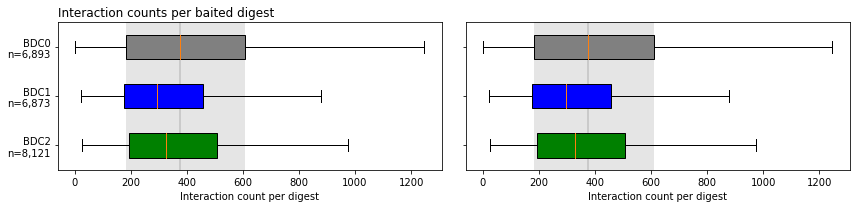

In [73]:
create_boxplot(
    BDC0_L=NUM_PER_BD_dict['BDC0']['INUM'],
    BDC0_R=NUM_PER_BD_dict['BDC0']['INUM'],
    BDC1_L=NUM_PER_BD_dict['BDC1']['INUM'],
    BDC1_R=NUM_PER_BD_dict['BDC1']['INUM'],
    BDC2_L=NUM_PER_BD_dict['BDC2']['INUM'],
    BDC2_R=NUM_PER_BD_dict['BDC2']['INUM'],
    SHOWFLIERS = False,
    TITLE='Interaction counts per baited digest',
    XLABEL_L='Interaction count per digest',
    XLABEL_R='Interaction count per digest',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_interaction_numbers_per_baited_digest.pdf')

In [74]:
# Perform Wilcoxon rank-sum test on differences
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['INUM'], NUM_PER_BD_dict['BDC1']['INUM']))
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['INUM'], NUM_PER_BD_dict['BDC2']['INUM']))
print(stats.ranksums(NUM_PER_BD_dict['BDC1']['INUM'], NUM_PER_BD_dict['BDC2']['INUM']))
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['INUM'], NUM_PER_BD_dict['BDC1']['INUM'] + NUM_PER_BD_dict['BDC2']['INUM']))

RanksumsResult(statistic=13.276140772926194, pvalue=3.183851724420754e-40)
RanksumsResult(statistic=6.732493504474321, pvalue=1.6677983538491603e-11)
RanksumsResult(statistic=-8.306072361759966, pvalue=9.892192200635429e-17)
RanksumsResult(statistic=11.232334036668258, pvalue=2.829049913220669e-29)


### Read pair counts per baited digest

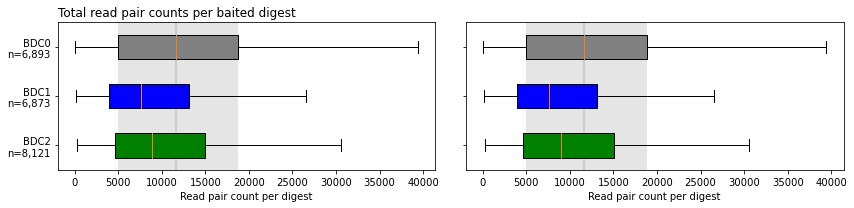

In [75]:
create_boxplot(
    BDC0_L=NUM_PER_BD_dict['BDC0']['RPNUM'],
    BDC0_R=NUM_PER_BD_dict['BDC0']['RPNUM'],
    BDC1_L=NUM_PER_BD_dict['BDC1']['RPNUM'],
    BDC1_R=NUM_PER_BD_dict['BDC1']['RPNUM'],
    BDC2_L=NUM_PER_BD_dict['BDC2']['RPNUM'],
    BDC2_R=NUM_PER_BD_dict['BDC2']['RPNUM'],
    SHOWFLIERS = False,
    TITLE='Total read pair counts per baited digest',
    XLABEL_L='Read pair count per digest',
    XLABEL_R='Read pair count per digest',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_total_read_pair_count_per_baited_digest.pdf')

In [76]:
# Perform Wilcoxon rank_sum test
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPNUM'], NUM_PER_BD_dict['BDC1']['RPNUM']))
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPNUM'], NUM_PER_BD_dict['BDC2']['RPNUM']))
print(stats.ranksums(NUM_PER_BD_dict['BDC1']['RPNUM'], NUM_PER_BD_dict['BDC2']['RPNUM']))
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPNUM'], NUM_PER_BD_dict['BDC1']['RPNUM'] + NUM_PER_BD_dict['BDC2']['RPNUM']))

RanksumsResult(statistic=18.99939332120304, pvalue=1.725271484641474e-80)
RanksumsResult(statistic=11.550377331756225, pvalue=7.349704271970546e-31)
RanksumsResult(statistic=-9.75013485308899, pvalue=1.8422338904861167e-22)
RanksumsResult(statistic=17.242130626807114, pvalue=1.2822274825202178e-66)


### Maximum read pair counts per baited digest (`RPMAX`)

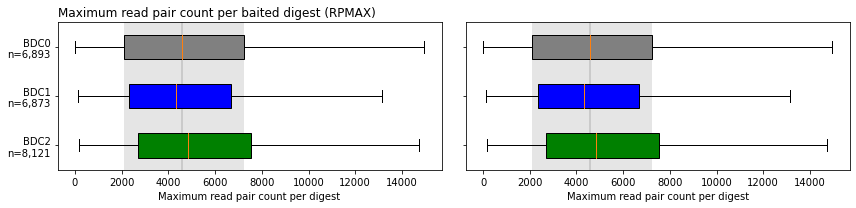

In [77]:
create_boxplot(
    BDC0_L=NUM_PER_BD_dict['BDC0']['RPMAX'],
    BDC0_R=NUM_PER_BD_dict['BDC0']['RPMAX'],
    BDC1_L=NUM_PER_BD_dict['BDC1']['RPMAX'],
    BDC1_R=NUM_PER_BD_dict['BDC1']['RPMAX'],
    BDC2_L=NUM_PER_BD_dict['BDC2']['RPMAX'],
    BDC2_R=NUM_PER_BD_dict['BDC2']['RPMAX'],
    SHOWFLIERS = False,
    TITLE='Maximum read pair count per baited digest (RPMAX)',
    XLABEL_L='Maximum read pair count per digest',
    XLABEL_R='Maximum read pair count per digest',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_maximum_read_pair_count_per_baited_digest_rpmax.pdf')

In [78]:
# Perform Wilcoxon rank_sum test
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPMAX'], NUM_PER_BD_dict['BDC1']['RPMAX']))
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPMAX'], NUM_PER_BD_dict['BDC2']['RPMAX']))
print(stats.ranksums(NUM_PER_BD_dict['BDC1']['RPMAX'], NUM_PER_BD_dict['BDC2']['RPMAX']))
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPMAX'], NUM_PER_BD_dict['BDC1']['RPMAX'] + NUM_PER_BD_dict['BDC2']['RPMAX']))

RanksumsResult(statistic=0.1657713379754545, pvalue=0.8683369029832778)
RanksumsResult(statistic=-8.909030470003737, pvalue=5.148076343536456e-19)
RanksumsResult(statistic=-9.927182738183037, pvalue=3.170878401848696e-23)
RanksumsResult(statistic=-5.341442846962456, pvalue=9.220968870534215e-08)


### Maximum read pair counts of type `2` and `3` per baited digest (`RPMAX2`)

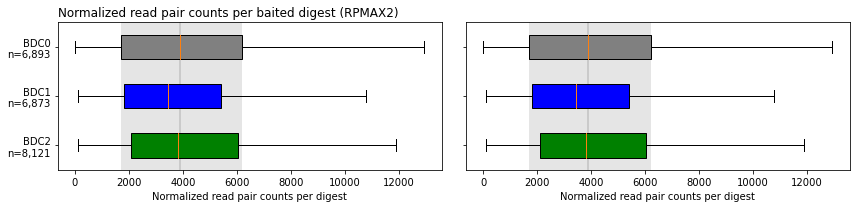

In [79]:
create_boxplot(
    BDC0_L=NUM_PER_BD_dict['BDC0']['RPMAX2'],
    BDC0_R=NUM_PER_BD_dict['BDC0']['RPMAX2'],
    BDC1_L=NUM_PER_BD_dict['BDC1']['RPMAX2'],
    BDC1_R=NUM_PER_BD_dict['BDC1']['RPMAX2'],
    BDC2_L=NUM_PER_BD_dict['BDC2']['RPMAX2'],
    BDC2_R=NUM_PER_BD_dict['BDC2']['RPMAX2'],
    SHOWFLIERS = False,
    TITLE='Normalized read pair counts per baited digest (RPMAX2)',
    XLABEL_L='Normalized read pair counts per digest',
    XLABEL_R='Normalized read pair counts per digest',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_normalized_read_pair_count_per_baited_digest_rpmax2.pdf')

In [80]:
# Perform Wilcoxon rank_sum test
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPMAX2'], NUM_PER_BD_dict['BDC1']['RPMAX2']))
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPMAX2'], NUM_PER_BD_dict['BDC2']['RPMAX2']))
print(stats.ranksums(NUM_PER_BD_dict['BDC1']['RPMAX2'], NUM_PER_BD_dict['BDC2']['RPMAX2']))
print(stats.ranksums(NUM_PER_BD_dict['BDC0']['RPMAX2'], NUM_PER_BD_dict['BDC1']['RPMAX2'] + NUM_PER_BD_dict['BDC2']['RPMAX2']))

RanksumsResult(statistic=4.2688274937827275, pvalue=1.9650316096899923e-05)
RanksumsResult(statistic=-3.839729243270652, pvalue=0.00012317007252934684)
RanksumsResult(statistic=-9.204397976416644, pvalue=3.4359180553681015e-20)
RanksumsResult(statistic=-0.04835490890603726, pvalue=0.9614333947183588)
